# Making our Data

In [ ]:
import torch
from sklearn.datasets import make_circles

In [ ]:
n_samples = 1000
X, y = make_circles(n_samples, noise= 0.05, random_state= 17)
len(X), len(y)

(1000, 1000)

In [ ]:
X[:5]

array([[-0.68133857, -0.31430033],
       [ 0.92640284, -0.08898004],
       [ 0.55120313, -0.54470931],
       [-0.87871979,  0.43304559],
       [-0.67477892, -0.39600037]])

In [ ]:
y[:5]

array([1, 0, 1, 0, 1])

In [ ]:
import pandas as pd
Data = pd.DataFrame({'X1' : X[:, 0], 'X2' : X[:, 1], 'label': y})
Data.head()

,X1,X2,label
0,-0.681339,-0.314300,1
1,0.926403,-0.088980,0
2,0.551203,-0.544709,1
3,-0.878720,0.433046,0
4,-0.674779,-0.396000,1


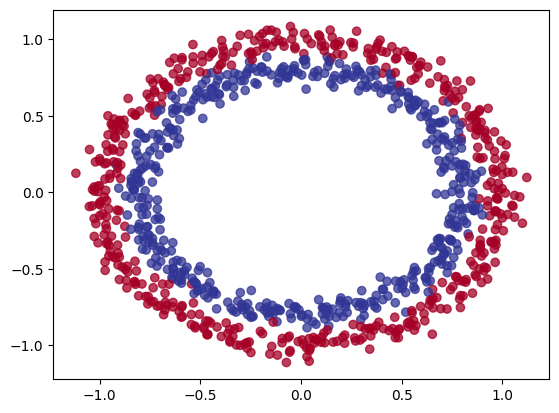

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x= Data['X1'], y= Data['X2'], c= Data['label'], cmap= plt.cm.RdYlBu, alpha= 0.75);

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
Data.label.value_counts()

1    500
0    500
Name: label, dtype: int64

### Turning data into tensors and doing train and test splits

In [ ]:
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.float).to(device)

In [ ]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 17)

In [ ]:
len(X_train), len(X_test)

(800, 200)

# Building a model

In [ ]:
import torch
from torch import nn

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        # Creating 2 layers
        self.layer1 = nn.Linear(in_features= 2, out_features= 5) #Takes 2 features and upscales it to 5 features
        self.layer2 = nn.Linear(in_features= 5, out_features= 1)

    def forward(self, x):
        return self.layer2(self.layer1(x))

In [ ]:
model_0 = CircleModelV1().to(device)
model_0

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device

device(type='cpu')

## We can replicate the above using nn.Sequential

In [ ]:
model_0 = nn.Sequential(
    nn.Linear(in_features= 2, out_features= 5),
    nn.Linear(in_features= 5, out_features= 1)
).to(device)

In [ ]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
torch.manual_seed(17)
model_0 = CircleModelV1().to(device)
model_0

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.0930,  0.0497],
                      [ 0.4670, -0.5319],
                      [-0.6656,  0.0699],
                      [-0.1662,  0.0654],
                      [-0.0449, -0.6828]])),
             ('layer1.bias',
              tensor([-0.6769, -0.1889, -0.4167, -0.4352, -0.2060])),
             ('layer2.weight',
              tensor([[-0.2523, -0.4471, -0.3215,  0.0897,  0.0588]])),
             ('layer2.bias', tensor([-0.3623]))])

In [ ]:
# Make initial predictions
with torch.inference_mode():
    initial_pred = model_0(X_test)
initial_pred[:10]

tensor([[ 0.0432],
        [-0.1520],
        [-0.0721],
        [-0.1864],
        [-0.1558],
        [ 0.1180],
        [ 0.0989],
        [-0.1992],
        [-0.0311],
        [ 0.1158]])

In [ ]:
loss_fn = nn.BCEWithLogitsLoss() # Sigmoid activation function It expects y_pred_logits

# nn.BCELoss() expects y_pred_probability

optimizer = torch.optim.SGD(params= model_0.parameters(), lr= 0.01)

In [ ]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Looking at logits

In [ ]:
with torch.inference_mode():
    y_logits = model_0(X_test)[:5]
y_logits

tensor([[ 0.0432],
        [-0.1520],
        [-0.0721],
        [-0.1864],
        [-0.1558]])

In [ ]:
# Using the sigmoid activation function on our logits which turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5108],
        [0.4621],
        [0.4820],
        [0.4535],
        [0.4611]])

In [ ]:
torch.round(y_pred_probs)

tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.]])

# Training and testing loop

In [ ]:
torch.manual_seed(17)
epochs = 100
for epoch in range(epochs):
    model_0.train()
    y_pred_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_pred_logits))

    loss = loss_fn(y_pred_logits, y_train)
    train_acc = accuracy_fn(y_pred, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        y_test_logits = model_0(X_test).squeeze()
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))

    test_loss = loss_fn(y_test_logits, y_test)
    test_acc = accuracy_fn(y_test_pred, y_test)

    if epoch % 10 == 0:
        print(f"epoch: {epoch}")
        print(f"Train Loss: {loss} and train accuracy: {train_acc}")
        print(f"Test Loss {test_loss} and test accuracy: {test_acc}")

epoch: 0
Train Loss: 0.6944043636322021 and train accuracy: 49.625
Test Loss 0.6946255564689636 and test accuracy: 50.0
epoch: 10
Train Loss: 0.6943444609642029 and train accuracy: 49.875
Test Loss 0.6946709156036377 and test accuracy: 49.5
epoch: 20
Train Loss: 0.6942873597145081 and train accuracy: 50.0
Test Loss 0.6947163939476013 and test accuracy: 49.5
epoch: 30
Train Loss: 0.6942325830459595 and train accuracy: 50.125
Test Loss 0.6947620511054993 and test accuracy: 49.0
epoch: 40
Train Loss: 0.6941800713539124 and train accuracy: 49.875
Test Loss 0.6948075890541077 and test accuracy: 48.5
epoch: 50
Train Loss: 0.6941297054290771 and train accuracy: 49.75
Test Loss 0.6948530673980713 and test accuracy: 48.5
epoch: 60
Train Loss: 0.6940814256668091 and train accuracy: 49.75
Test Loss 0.6948983073234558 and test accuracy: 49.0
epoch: 70
Train Loss: 0.6940348744392395 and train accuracy: 49.625
Test Loss 0.694943368434906 and test accuracy: 48.5
epoch: 80
Train Loss: 0.69399034976959

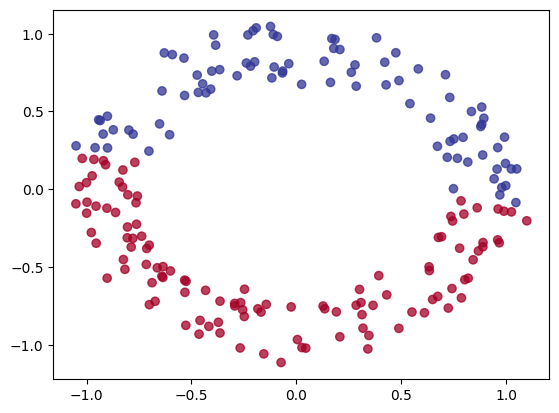

In [ ]:
with torch.inference_mode():
    y_test_logits = model_0(X_test)
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))
plt.scatter(x= X_test[:, 0].cpu(), y= X_test[:, 1].cpu(), c= y_test_pred.cpu(), cmap= plt.cm.RdYlBu, alpha= 0.75);

In [ ]:
import requests
from pathlib import Path
# Download helper function from Learn PyTorch repo
if Path('helper_functions.py').is_file():
    print("The file already exists skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

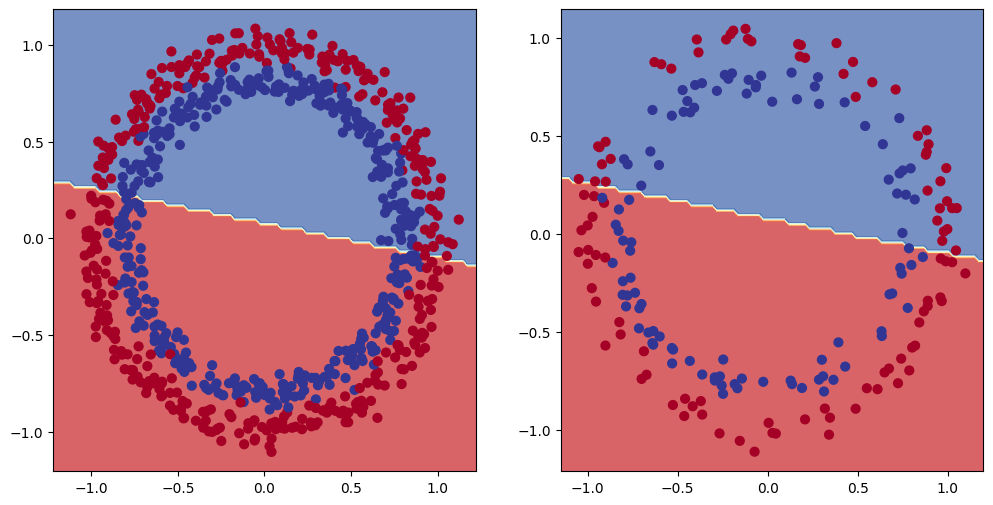

In [ ]:
plt.figure(figsize= (12, 6))
plt.subplot(1, 2, 1)
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plot_decision_boundary(model_0, X_test, y_test)

## Imporving the model
* Add more layers
* Add more hidden units
* Fit for more epochs
* Changing the activation function
* Change the learning rate
* Changing the loss function

### Add a few more layers to our model and increase the number of hidden units

In [ ]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features= 2, out_features= 16)
        self.layer2 = nn.Linear(in_features= 16, out_features= 32)
        self.layer3 = nn.Linear(in_features= 32, out_features= 16)
        self.layer4 = nn.Linear(in_features= 16, out_features= 1)

    def forward(self, x):
        return self.layer4(self.layer3(self.layer2(self.layer1(x))))

In [ ]:
torch.manual_seed(17)
model_1 = CircleModelV2()
model_1.to(device)
# model_1.state_dict()

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=1, bias=True)
)

In [ ]:
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params= model_1.parameters(), lr= 0.01)

In [ ]:
epochs = 300
for epoch in range(epochs):
    model_1.train()
    y_pred_logits = model_1(X_train).squeeze()
    y_pred_probs = torch.round(torch.sigmoid(y_pred_logits))

    loss = loss_fn(y_pred_logits, y_train)
    train_acc = accuracy_fn(y_pred_probs, y_train)

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        y_test_logits = model_1(X_test).squeeze()
        y_test_probs = torch.round(torch.sigmoid(y_test_logits))

    test_loss = loss_fn(y_test_logits, y_test)
    test_acc = accuracy_fn(y_test_probs, y_test)

    if epoch % 20 == 0:
        print(f"\nFor epoch: {epoch}")
        print(f"Train loss: {loss}")
        print(f"Train accuracy {train_acc}")
        print(f"Test Loss: {test_loss}")
        print(f"Test accuracy: {test_acc}")



For epoch: 0
Train loss: 0.6939460635185242
Train accuracy 57.125
Test Loss: 0.694530189037323
Test accuracy: 56.49999999999999

For epoch: 20
Train loss: 0.6937696933746338
Train accuracy 58.25
Test Loss: 0.6945450305938721
Test accuracy: 56.99999999999999

For epoch: 40
Train loss: 0.6936245560646057
Train accuracy 57.25
Test Loss: 0.6945852041244507
Test accuracy: 51.5

For epoch: 60
Train loss: 0.6935040354728699
Train accuracy 55.25
Test Loss: 0.694644033908844
Test accuracy: 48.0

For epoch: 80
Train loss: 0.6934030055999756
Train accuracy 54.75
Test Loss: 0.6947165727615356
Test accuracy: 49.0

For epoch: 100
Train loss: 0.6933174729347229
Train accuracy 53.5
Test Loss: 0.6947988867759705
Test accuracy: 49.5

For epoch: 120
Train loss: 0.693244457244873
Train accuracy 52.75
Test Loss: 0.6948882937431335
Test accuracy: 49.0

For epoch: 140
Train loss: 0.6931815147399902
Train accuracy 52.625
Test Loss: 0.6949822306632996
Test accuracy: 49.5

For epoch: 160
Train loss: 0.69312673

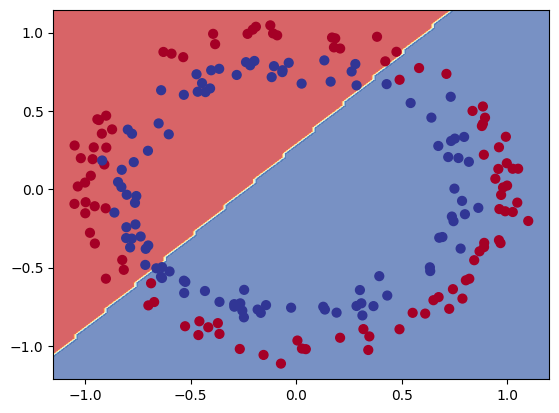

In [ ]:
plot_decision_boundary(model_1, X_test, y_test)

## Lets see if our model can fit on a straight line


In [ ]:
weight = 1.7
bias = 5
X_regression = torch.arange(0, 80, 0.8).unsqueeze(dim= 1).to(device)
y_regression = weight * X_regression + bias
y_regression.device

device(type='cpu')

In [ ]:
len(y_regression)

100

In [ ]:
X_train_regression, X_test_regression = X_regression[:80], X_regression[80:]
y_train_regression, y_test_regression = y_regression[:80], y_regression[80:]
len(X_train_regression)

80

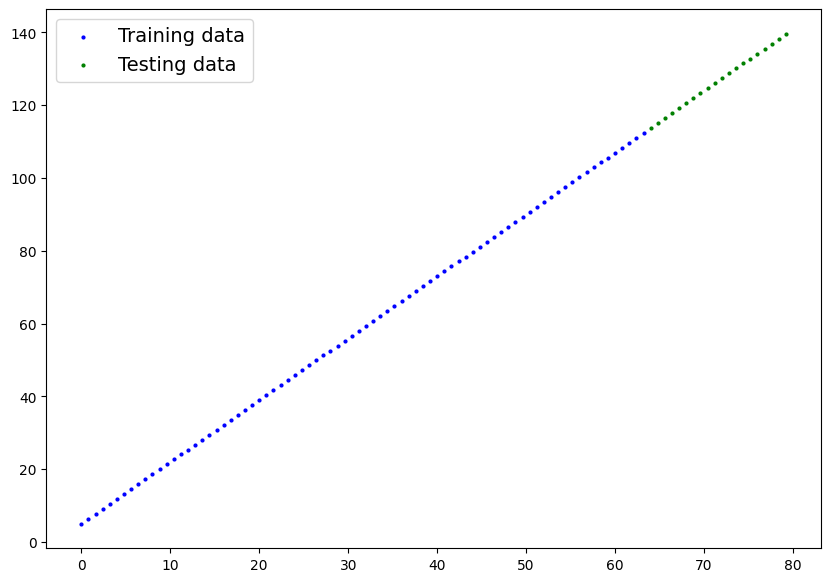

In [ ]:
plot_predictions(X_train_regression.cpu(), y_train_regression.cpu(), X_test_regression.cpu(), y_test_regression.cpu())

In [ ]:
class LinearRegressionModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features= 1, out_features= 8)
        self.layer2 = nn.Linear(in_features= 8, out_features= 16)
        self.layer3 = nn.Linear(in_features= 16, out_features= 8)
        self.layer4 = nn.Linear(in_features= 8, out_features= 1)

    def forward(self, x):
        return self.layer4(self.layer3(self.layer2(self.layer1(x))))

In [ ]:
torch.manual_seed(17)
model_regression = LinearRegressionModel2()
model_regression.to(device)

LinearRegressionModel2(
  (layer1): Linear(in_features=1, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=8, bias=True)
  (layer4): Linear(in_features=8, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(params= model_regression.parameters(), lr= 0.000063)

In [ ]:
epochs = 1401
for epoch in range(epochs):
    model_regression.train()
    y_train_pred = model_regression(X_train_regression)

    loss = loss_fn(y_train_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_regression.eval()
    with torch.inference_mode():
        y_test_pred = model_regression(X_test_regression)


    test_loss = loss_fn(y_test_pred, y_test_regression)
    if epoch % 140 == 0:
        print(f"\nFor epoch: {epoch}")
        print(f"Train loss: {loss}")
        print(f"Test Loss: {test_loss}")


For epoch: 0
Train loss: 3772.795654296875
Test Loss: 8614.611328125

For epoch: 140
Train loss: 6.632044315338135
Test Loss: 12.627493858337402

For epoch: 280
Train loss: 5.872339725494385
Test Loss: 11.21019172668457

For epoch: 420
Train loss: 5.187320232391357
Test Loss: 9.92634105682373

For epoch: 560
Train loss: 4.562733173370361
Test Loss: 8.750497817993164

For epoch: 700
Train loss: 3.989287853240967
Test Loss: 7.666071891784668

For epoch: 840
Train loss: 3.461106061935425
Test Loss: 6.663470268249512

For epoch: 980
Train loss: 2.9748375415802
Test Loss: 5.735079288482666

For epoch: 1120
Train loss: 2.529587745666504
Test Loss: 4.649580478668213

For epoch: 1260
Train loss: 5.918997287750244
Test Loss: 2.397339344024658

For epoch: 1400
Train loss: 2.511216640472412
Test Loss: 0.4390830397605896


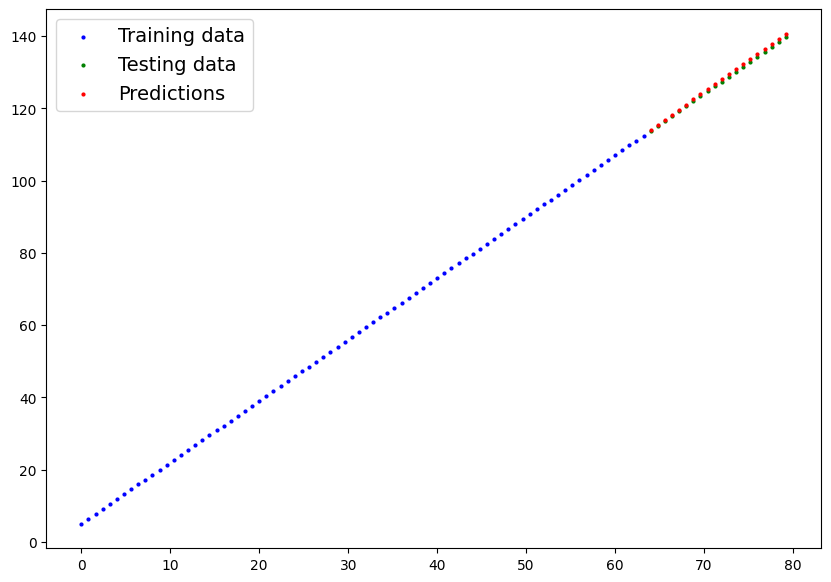

In [ ]:
with torch.inference_mode():
    y_test_pred = model_regression(X_test_regression)
plot_predictions(X_train_regression.cpu(), y_train_regression.cpu(), X_test_regression.cpu(), y_test_regression.cpu(), predictions= y_test_pred.cpu())

## The model works almost perfectly on Regression task
**The missing piece is non linearity**

# Recreating the data

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
X, y = make_circles(n_samples= 1000, noise= 0.04, random_state= 17)
data = pd.DataFrame({'X1' : X[:, 0], 'X2' : X[:, 1], 'label' : y})
data.head(8)

,X1,X2,label
0,-0.688976,-0.321379,1
1,0.941106,-0.073697,0
2,0.542950,-0.559050,1
3,-0.886024,0.427018,0
4,-0.665629,-0.415658,1
5,0.600186,0.812827,0
6,-0.603419,-0.574058,1
7,0.331299,0.915430,0


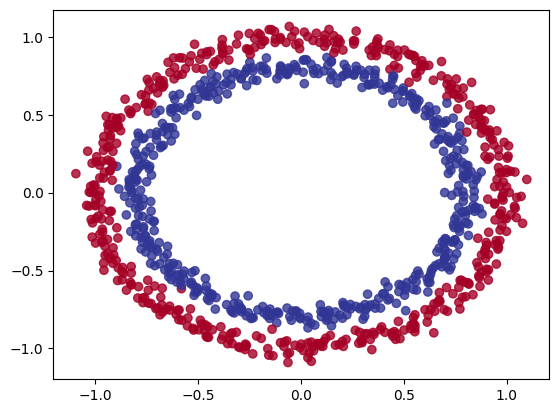

In [ ]:
plt.scatter(x= data['X1'], y= data['X2'], c= data['label'], cmap= plt.cm.RdYlBu, alpha= 0.8);

In [ ]:
X = torch.from_numpy(X).to(device)
y = torch.from_numpy(y).to(device)


In [ ]:
X = X.type(torch.float)
y = y.type(torch.float)
y.dtype, X.dtype

(torch.float32, torch.float32)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 17, test_size= 0.2)

## Building a non linear model

In [ ]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features= 2, out_features= 8)
        self.layer2 = nn.Linear(in_features= 8, out_features= 16)
        self.layer3 = nn.Linear(in_features= 16, out_features= 8)
        self.layer4 = nn.Linear(in_features= 8, out_features= 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer4(self.relu(self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))))

In [ ]:
model_3 = CircleModelV3()
model_3.to(device)

CircleModelV3(
  (layer1): Linear(in_features=2, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=8, bias=True)
  (layer4): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params= model_3.parameters(), lr= 0.29)

In [ ]:
torch.manual_seed(17)
epochs = 1801
for epoch in range(epochs):
    model_3.train()
    y_train_logits = model_3(X_train).squeeze()
    y_train_pred = torch.round(torch.sigmoid(y_train_logits))

    loss = loss_fn(y_train_logits, y_train)
    train_acc = accuracy_fn(y_train_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        y_test_logits = model_3(X_test).squeeze()
        y_test_pred = torch.round(torch.sigmoid(y_test_logits))
    test_loss = loss_fn(y_test_logits, y_test)
    test_acc = accuracy_fn(y_test_pred, y_test)

    if epoch % 600 == 0:
        print(f"\nFor epoch: {epoch}")
        print(f"Train loss: {loss}")
        print(f"Train accuracy {train_acc}")
        print(f"Test Loss: {test_loss}")
        print(f"Test accuracy: {test_acc}")



For epoch: 0
Train loss: 0.6917002201080322
Train accuracy 50.375
Test Loss: 0.6902540326118469
Test accuracy: 56.49999999999999

For epoch: 600
Train loss: 0.08020143955945969
Train accuracy 97.875
Test Loss: 0.09190297871828079
Test accuracy: 97.0

For epoch: 1200
Train loss: 0.3631063997745514
Train accuracy 83.875
Test Loss: 0.4257170855998993
Test accuracy: 79.0

For epoch: 1800
Train loss: 0.05619382858276367
Train accuracy 99.25
Test Loss: 0.06347108632326126
Test accuracy: 99.0


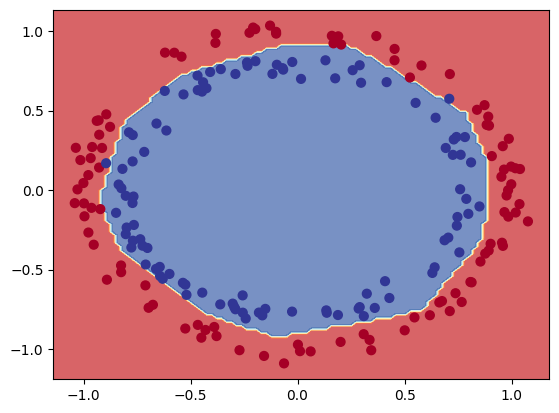

In [ ]:
plot_decision_boundary(model_3, X_test, y_test)

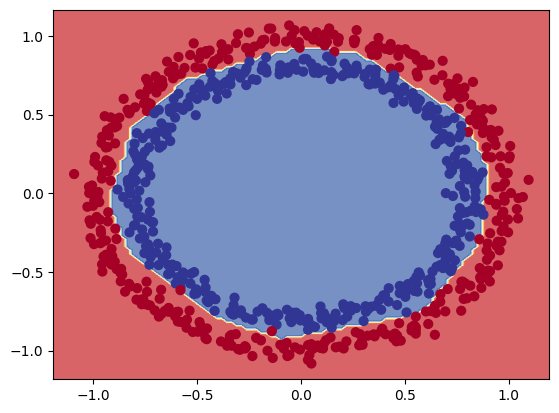

In [ ]:
plot_decision_boundary(model_3, X_train, y_train)

# Putting a multiclass classification problem
* We use softmax activation function
* We use Cross Entropy

## Creating a toy dataset

In [ ]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from sklearn.datasets import make_blobs
num_classes = 4
num_features = 2
X_blobs, y_blobs = make_blobs(n_samples= 1000, n_features= num_features, centers= num_classes, cluster_std= 1.5, random_state= 8)
X_blobs = torch.from_numpy(X_blobs).type(torch.float).to(device)
y_blobs = torch.from_numpy(y_blobs).type(torch.int64).to(device)

In [ ]:
torch.unique(y_blobs)

tensor([0, 1, 2, 3], device='cuda:0')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_blobs, y_blobs, test_size= 0.2, random_state= 5)

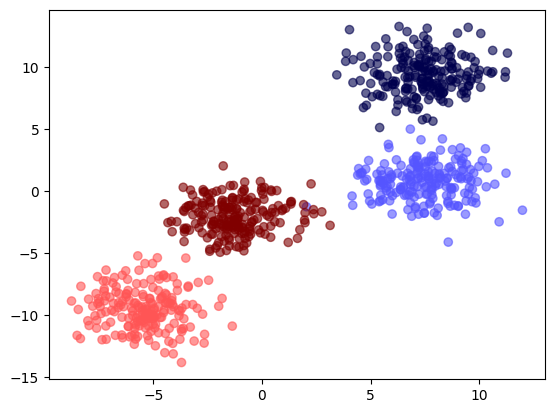

In [ ]:
plt.scatter(x= X_train[:, 0].cpu(), y= X_train[:, 1].cpu(), c= y_train.cpu(), cmap= plt.cm.seismic, alpha= 0.6);

In [ ]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units= 8):
        '''Initializes the multiclass classification model

        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of output features (number of classes)
            hidden_units (int): Number of hidden units between layers, default 8
        '''
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features= input_features, out_features= hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units * 2),
            # nn.ReLU(),
            nn.Linear(in_features= hidden_units * 2, out_features= hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

In [ ]:
torch.manual_seed(17)
model_blob = BlobModel(2, 4)
model_blob.to(device)

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
device

'cuda'

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params= model_blob.parameters(), lr= 0.15)

In [ ]:
with torch.inference_mode():
    y_logits = model_blob(X_test)
    y_pred_prob = torch.softmax(y_logits, dim= 1)
y_pred_prob[:10]

tensor([[0.2612, 0.3411, 0.1926, 0.2051],
        [0.2612, 0.3411, 0.1926, 0.2051],
        [0.2526, 0.3707, 0.1811, 0.1956],
        [0.2540, 0.3646, 0.1858, 0.1955],
        [0.2659, 0.3569, 0.1984, 0.1789],
        [0.2612, 0.3411, 0.1926, 0.2051],
        [0.2617, 0.3403, 0.1923, 0.2057],
        [0.2529, 0.4567, 0.1621, 0.1283],
        [0.2617, 0.3411, 0.1922, 0.2050],
        [0.2561, 0.4360, 0.1687, 0.1391]], device='cuda:0')

In [ ]:
y_preds = torch.argmax(y_pred_prob, dim= 1)
y_preds[:10]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [ ]:
torch.argmax(y_pred_prob[0])

tensor(1, device='cuda:0')

In [ ]:
torch.manual_seed(17)
epochs = 101

for epoch in range(epochs):
    model_blob.train()
    y_train_logits = model_blob(X_train)
    y_train_probs = torch.softmax(y_train_logits, dim= 1)
    y_train_preds = torch.argmax(y_train_probs, dim= 1)
    train_acc = accuracy_fn(y_train_preds, y_train)

    loss = loss_fn(y_train_logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_blob.eval()
    with torch.inference_mode():
        y_test_logits = model_blob(X_test)
        y_test_probs = torch.softmax(y_test_logits, dim= 1)
        y_test_preds = torch.argmax(y_test_probs, dim= 1)

        test_loss = loss_fn(y_test_logits, y_test)
        test_acc = accuracy_fn(y_test_preds, y_test)

    if epoch % 20 == 0:
        print(f"\nFor epoch: {epoch}")
        print(f"Train loss: {loss:.4f}")
        print(f"Train accuracy {train_acc}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test accuracy: {test_acc}")



For epoch: 0
Train loss: 1.4798
Train accuracy 0.5
Test Loss: 0.8990
Test accuracy: 54.50000000000001

For epoch: 20
Train loss: 0.2271
Train accuracy 91.5
Test Loss: 0.1863
Test accuracy: 98.0

For epoch: 40
Train loss: 0.0937
Train accuracy 97.75
Test Loss: 0.0779
Test accuracy: 99.5

For epoch: 60
Train loss: 0.0464
Train accuracy 99.625
Test Loss: 0.0419
Test accuracy: 100.0

For epoch: 80
Train loss: 0.0319
Train accuracy 99.75
Test Loss: 0.0292
Test accuracy: 100.0

For epoch: 100
Train loss: 0.0256
Train accuracy 99.75
Test Loss: 0.0231
Test accuracy: 100.0


In [ ]:
import numpy as np
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.seismic, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.seismic, alpha= 0.8)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

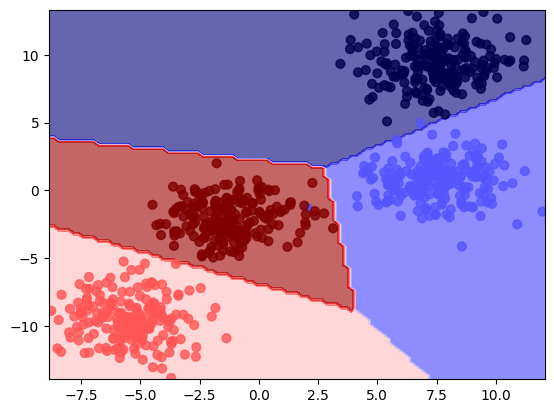

In [ ]:
plot_decision_boundary(model_blob, X_train, y_train);

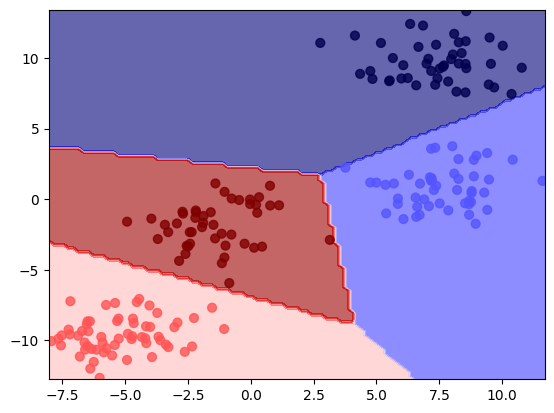

In [ ]:
plot_decision_boundary(model_blob, X_test, y_test);

## Using ReLU

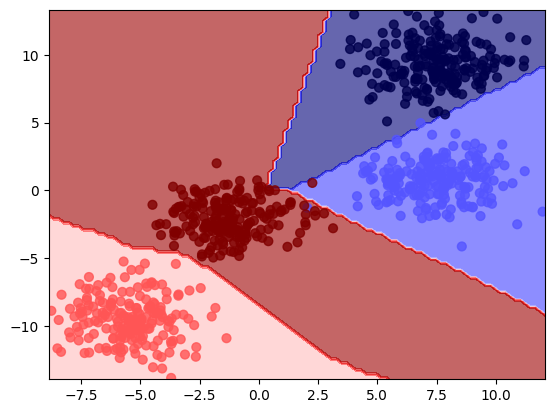

In [ ]:
plot_decision_boundary(model_blob, X_train, y_train);

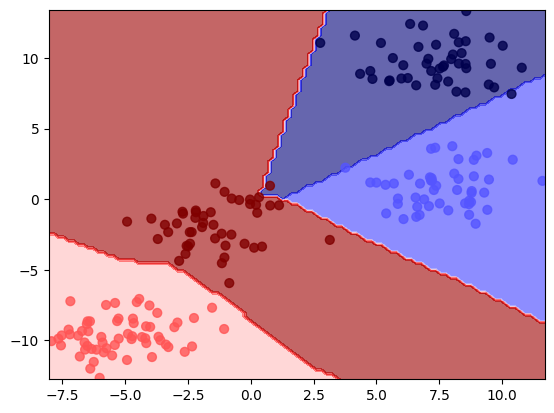

In [ ]:
plot_decision_boundary(model_blob, X_test, y_test);